# DESI DR1 Stream Tutorial

Welcome to the 2025 version of our stellar stream characterization tutorial notebook. This notebook will walk you through using data from the DESI Milky Way Survey data from the first full public release!

Below, we're going to import the packages we'll be using.

#-----------------------#

Look here for stuff to change throughout the notebook!

#-----------------------#

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats as stats
from astropy.io import fits
from astropy import table
import matplotlib
import matplotlib.patheffects as path_effects
import importlib
import stream_functions as stream_funcs
importlib.reload(stream_funcs)
import galstreams
import emcee
import corner
from astropy import units as u
from collections import OrderedDict
import time
from scipy import optimize, stats
import matplotlib.colors as mcolors
colors = mcolors.CSS4_COLORS
color_names = list(colors.keys())
import streamTutorial as st
import copy
importlib.reload(st);


Next, let's input our DESI MWS DR1 data. 

In [4]:
importlib.reload(st)
# Add the path to the DESI data and STREAMFINDER data below
#-----------------------#
desi_path = '/raid/DESI_public/data/mwsall-pix-iron.fits'
sf_path = '/raid/catalogs/streamfinder_gaiadr3.fits'
#-----------------------#

Data = st.Data(desi_path, sf_path)

print('Now our desi data has been loaded under Data.desi_data')


Length of DESI Data before Cuts: 6372607
Length after NaN cut: 4075716
Adding empirical FEH calibration (can find uncalibrated data in column['FEH_uncalib])
Length after NaN cut: 4075716
Adding empirical FEH calibration (can find uncalibrated data in column['FEH_uncalib])
Now our desi data has been loaded under Data.desi_data
Now our desi data has been loaded under Data.desi_data


# Pick Stream

We'll pick a stream to work with by entering it in 
`st.stream(Data, streamName='SoI-I21', streamNo=42)`.

Initializing this stream object will add an attribute to the `Data` object, accessed either through

`Data.confirmed_sf_and_desi` or `SoI.data.confirmed_sf_and_desi`

It will also calculate the *stream coordinates* $\phi_1$ and $\phi_2$. This is achieved by rotating the right ascension and declination such that the length of the stream lies along $\phi_2 \sim 0$, and the center of the stream is $\phi_1 \sim 0$.

In [17]:
del SoI

In [18]:
importlib.reload(stream_funcs)

#-----------------------#
streamName= 'Slidr-I24' #'Sylgr-I21'
streamNo=39 # 42
#-----------------------#

importlib.reload(st)
SoI = st.stream(Data, streamName, streamNo)

Importing galstreams module...
Initializing galstreams library from master_log... 
0.9999999999999996
Creating combined DataFrame of SF and DESI
0.9999999999999996
Creating combined DataFrame of SF and DESI
No stars were cut - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 330, Number of DESI and SF stars: 48
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
No stars were cut - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 330, Number of DESI and SF stars: 48
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 282
Stars only in SF3: 282
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.SoI_streamfinder['phi

Lets take a look at the rotated stream below

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:552: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



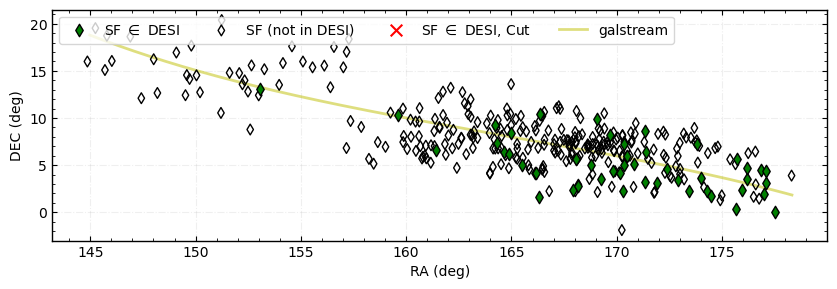

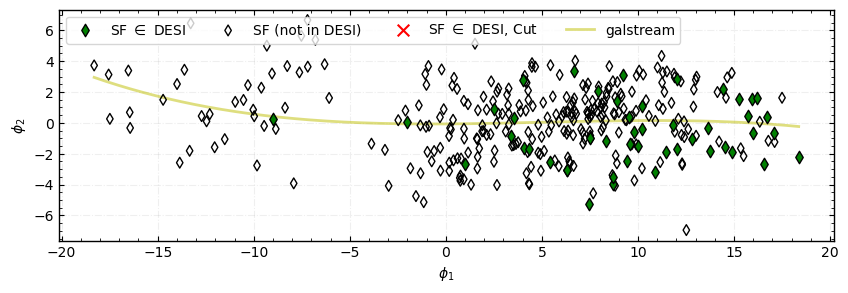

In [19]:
importlib.reload(st)
plt_soi = st.StreamPlotter(SoI)

plt_soi.on_sky(stream_frame=False)
plt_soi.on_sky(stream_frame=True)

If the galstream rotation doesn't look right, we can make our own rotation matrix:
# WIP

# Trimming DESI Data
We have lots of DESI data, lets cut that down with the following steps:
- Perform a distance cut to remove stars too nearby
- Perform an RA/DEC cut to remove stars on different parts of the sky
- Trim stars with kinematics nothing like the STREAMFINDER stars
- Trim stars that are too metal rich
- Trim stars that fall outside of the best-fit stellar population model

The first two bullet points can be achieved using a handy function we have stored in `stream_functions.py`

`stream_funcs.threeD_max_min_mask`

In [129]:
importlib.reload(st)
selection_fine = st.Selection(SoI.data.desi_data)

# We want to get the ra and dec from STREAMFINDER stars for this function so we can cut around it


#-----------------------#
ra_cut = 5 #deg
dec_cut = 5 #deg
#-----------------------#

selection_fine.add_mask(name='3D',
        mask_func=lambda df: stream_funcs.threeD_max_min_mask(
        df['TARGET_RA'],        
        df['TARGET_DEC'],         
        df['PARALLAX'],       
        df['PARALLAX_ERROR'],   
        SoI.data.SoI_streamfinder['RAdeg'],         
        SoI.data.SoI_streamfinder['DEdeg'],        
        SoI.min_dist,              
        ra_cut,dec_cut) #<-----------------------# dec cut, ra cut (wide cuts for now)
)

Selection object created for DataFrame with 4075716 rows.
Mask added: '3D'


Once we've done all our cuts, we can get all our masks in one using `final_mask = st.Selection.get_final_mask()`

Combining masks...
...'3D' selected 302145 stars
Selection: 302145 / 4075716 stars.
No stars were cut - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 330, Number of DESI and SF stars: 48
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
No stars were cut - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 330, Number of DESI and SF stars: 48
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 282
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:577: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.plot(

Stars only in SF3: 282
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:577: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may 

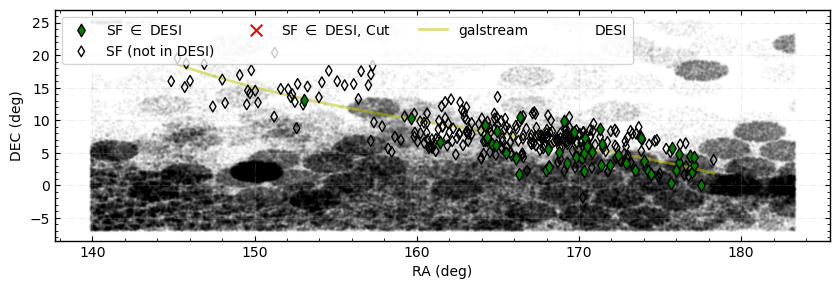

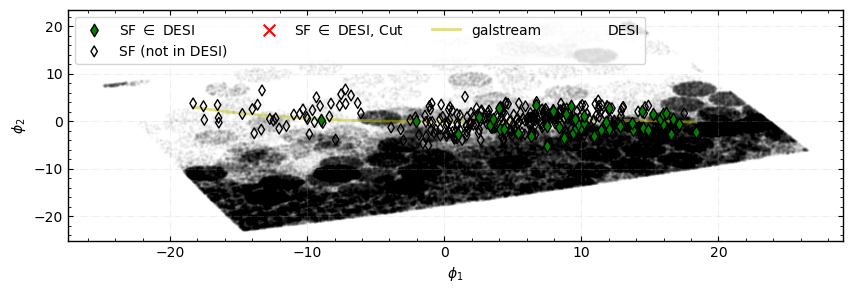

In [130]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data

final_mask = selection_fine.get_final_mask()

# Using the new method that replaces the 4-line pattern
trimmed_stream = SoI.mask_stream(final_mask)

plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.on_sky(showStream=True, background=True, stream_frame=False)
plt_trim.on_sky(showStream=True, background=True)

Lets also look at our parallax cut:

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:643: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.set_ylabel(label_y)



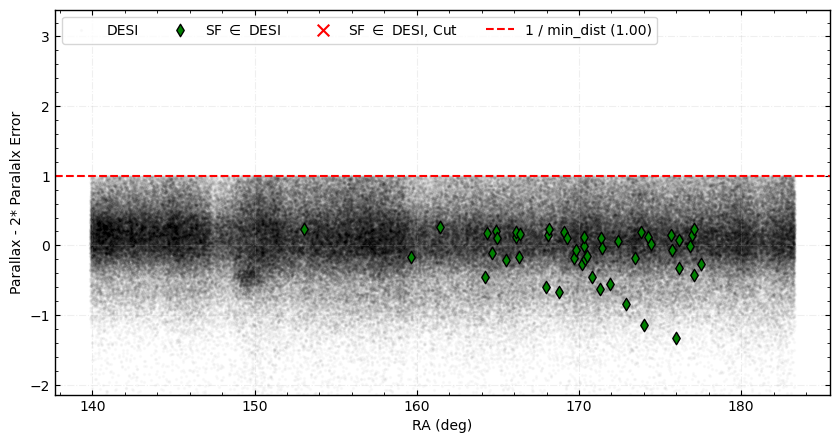

In [131]:
plt_trim.plx_cut()

#del plt_trim, trimmed_desi, trimmed_stream # clear memory

Now that we've visualized the stream in the stream-frame, we can get a bit more specific with our on-sky cuts.

In [132]:
#-----------------------#
phi2_wiggle=5 #[deg]
#-----------------------#

selection_fine.add_mask(name='phi2',
        mask_func=lambda df: (df['phi2'] < phi2_wiggle) & (df['phi2'] > -1*phi2_wiggle))

Mask added: 'phi2'


In [133]:
# del plt_trim

Combining masks...
...'3D' selected 302145 stars
...'phi2' selected 355974 stars
Selection: 85120 / 4075716 stars.
Created cut_confirmed_sf_and_desi with 1 stars that were filtered out
Number of stars in SF: 330, Number of DESI and SF stars: 47
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b


Stars only in SF3: 283
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:577: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.plot(



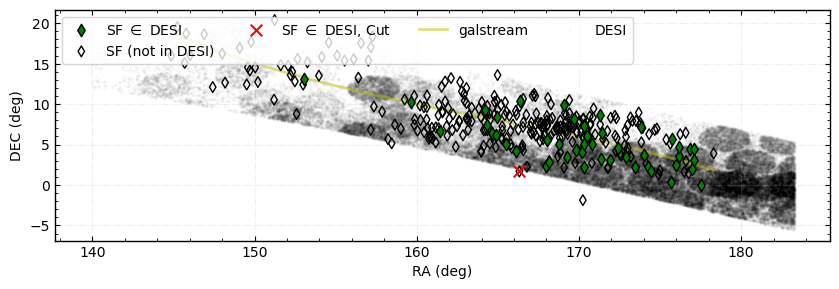

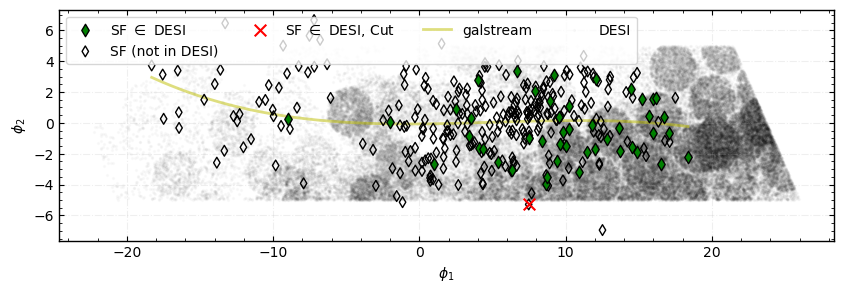

In [134]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data
final_mask = selection_fine.get_final_mask()

# Using the new method that replaces the 4-line pattern
trimmed_stream = SoI.mask_stream(final_mask)

plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.on_sky(showStream=True, background=True, stream_frame=False)
plt_trim.on_sky(showStream=True, background=True)

# Metallicity and Isochrone Cuts

Lets grab the stream's known metallicity from STREAMFINDER

In [135]:
sf3_table = pd.read_csv('./data/sf3_only_table.csv')


sf_streamname = streamName.rsplit('-', 1)[0] #If this fails, manually enter the stream name from the first table.
metallicity = sf3_table[sf3_table['Stream'] == sf_streamname]['Metallicities'].values
print(f"{sf_streamname} Metallicity: {metallicity}")
print(f'Mass Fraction (Z) Guess: {0.0181 * 10 ** metallicity}')


Slidr Metallicity: [-1.7]
Mass Fraction (Z) Guess: [0.00036114]


/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:820: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  self.data.desi_data[col_y],



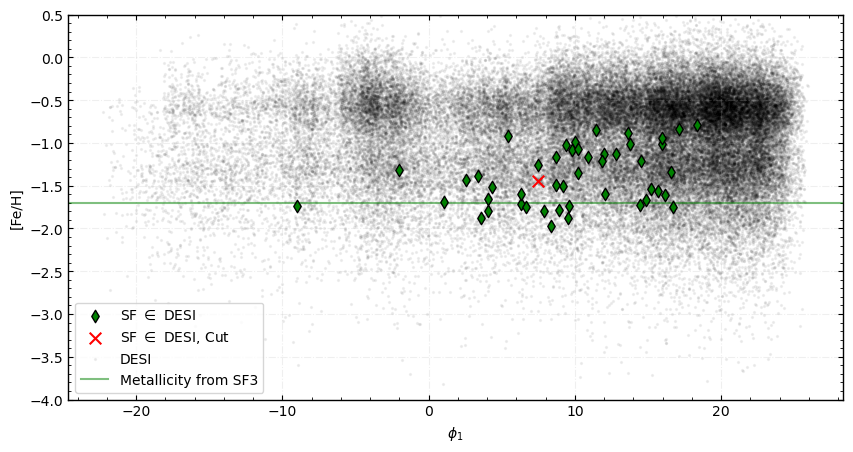

In [136]:
plt_trim.plot_params['background']['alpha']=0.05
plot = plt_trim.feh_plot(showStream=True, background=True)
ax = plot[1]
ax.axhline(metallicity, color='g', linestyle='solid', label='Metallicity from SF3', alpha=0.5)
ax.legend()

Now lets trim stars that are too metal rich!

In [137]:
#-----------------------#
feh_cut = -0.5 # [dex]
#-----------------------#

selection_fine.add_mask(name='feh',
        mask_func=lambda df: (df['FEH'] < feh_cut))

Mask added: 'feh'


...'3D' selected 302145 stars
...'phi2' selected 355974 stars
...'feh' selected 1941791 stars
Selection for specified masks: 53519 / 4075716 stars.
Created cut_confirmed_sf_and_desi with 1 stars that were filtered out
Number of stars in SF: 330, Number of DESI and SF stars: 47
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 283
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:820: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  self.data.desi_data[col_y],

Stars only in SF3: 283
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:820: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  self.data.desi_data[col_y],



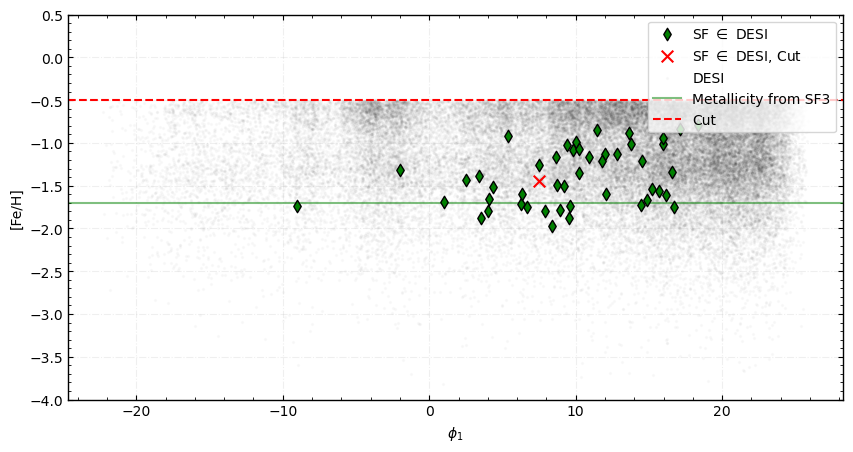

In [ ]:
#del trimmed_stream, plt_trim # clear memory
mask = selection_fine.get_masks(['3D', 'phi2', 'feh'])
trimmed_stream = SoI.mask_stream(mask)


plt_trim = st.StreamPlotter(trimmed_stream)
plot = plt_trim.feh_plot(showStream=True, background=True)
ax = plot[1]
ax.axhline(metallicity, color='g', linestyle='solid', label='Metallicity from SF3', alpha=0.5)
ax.axhline(feh_cut, color='red', linestyle='--', label='Cut')
ax.legend(loc='upper right')

# Kinematic Cuts

DESI's radial velocity

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:700: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  )

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:705: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  #             self.data.SoI_galstream.,

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:710: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  #             self.data.SoI_galstream.gal_phi2,



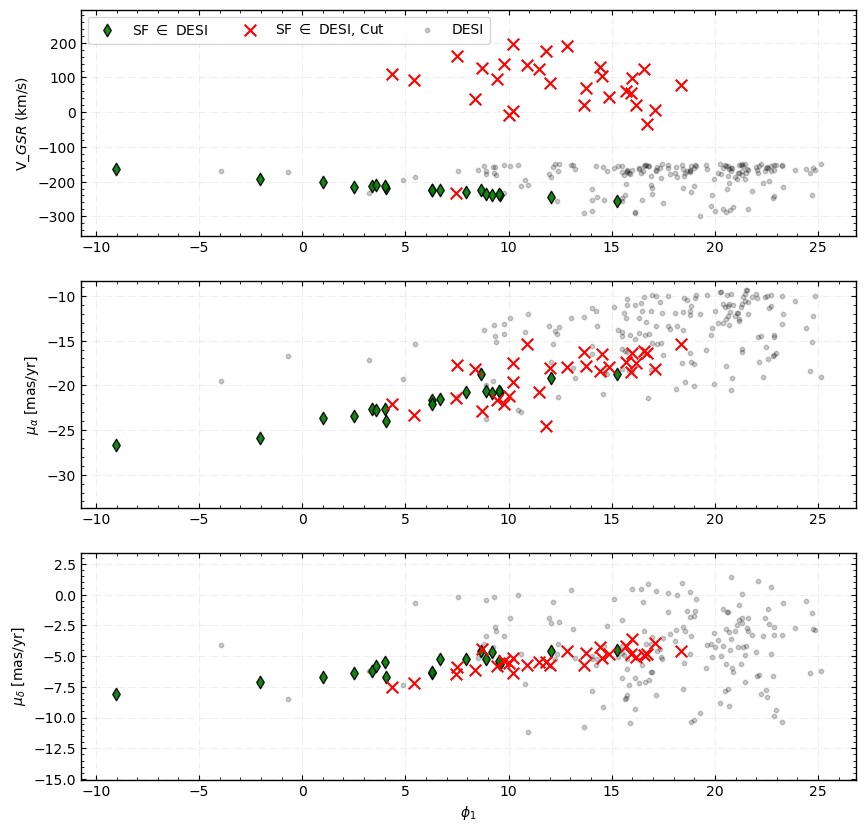

In [147]:
importlib.reload(st)
plt_trim.plot_params['background']['alpha']=0.2
plt_trim.kin_plot(showStream=True, background=True, show_sf_only=False)

In [148]:
#-----------------------#
vgsr_max=-150 #[km/s]
vgsr_min=-300
#-----------------------#

selection_fine.add_mask(name='VGSR',
        mask_func=lambda df: (df['VGSR'] < vgsr_max) & (df['VGSR'] > vgsr_min))

Mask added: 'VGSR'


In [149]:
#-----------------------#
pmra_wiggle = 6 # [mas/yr]
#-----------------------#

# selection_fine.add_mask(name='PMRA',
#         mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))
# selection_fine.add_mask(name='PMRA',
#         mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))

selection_fine.add_mask(
    name='PMRA',
    mask_func=lambda df: (
        (
            df['PMRA'] >= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmRA'] - pmra_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmRA'] - pmra_wiggle])
        ) &
        (
            df['PMRA'] <= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmRA'] + pmra_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmRA'] + pmra_wiggle])
        ) ))

Mask added: 'PMRA'


In [150]:
# #-----------------------#
# pmdec_max= -1 #[mas/yr]
# pmdec_min= -10
# #-----------------------#

# selection_fine.add_mask(name='PMDEC',
#         mask_func=lambda df: (df['PMDEC'] < pmdec_max) & (df['PMDEC'] > pmdec_min))

#-----------------------#
pmdec_wiggle = 6 # [mas/yr]
#-----------------------#

# selection_fine.add_mask(name='PMRA',
#         mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))
# selection_fine.add_mask(name='PMRA',
#         mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))

selection_fine.add_mask(
    name='PMDEC',
    mask_func=lambda df: (
        (
            df['PMDEC'] >= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmDE'] - pmdec_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmDE'] - pmdec_wiggle])
        ) &
        (
            df['PMDEC'] <= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmDE'] + pmdec_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmDE'] + pmdec_wiggle])
        ) ))

Mask added: 'PMDEC'


## Lets look at our cuts!

In [151]:
selection_fine.list_masks()

Active masks:
- 3D
- phi2
- feh
- VGSR
- PMRA
- PMDEC


...'3D' selected 302145 stars
...'phi2' selected 355974 stars
...'feh' selected 1941791 stars
...'VGSR' selected 249744 stars
...'PMRA' selected 364200 stars
...'PMDEC' selected 2364684 stars
Selection for specified masks: 188 / 4075716 stars.
Created cut_confirmed_sf_and_desi with 29 stars that were filtered out
Number of stars in SF: 330, Number of DESI and SF stars: 19
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 311


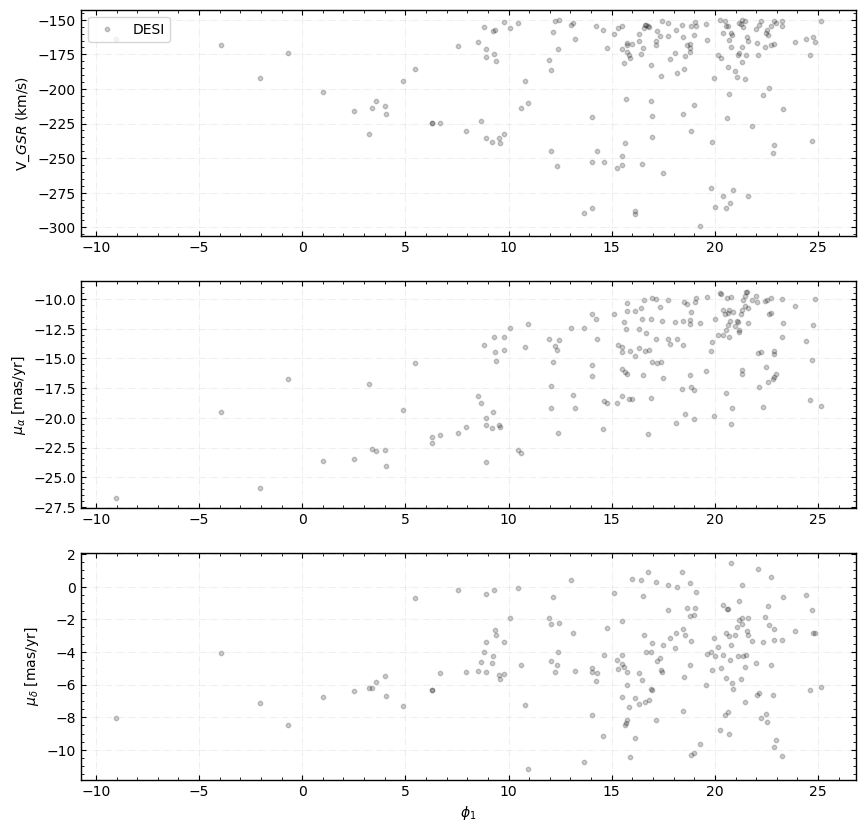

In [155]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data
mask = selection_fine.get_masks(['3D', 'phi2', 'feh', 'VGSR', 'PMRA', 'PMDEC'])

# Using the new method that replaces the 4-line pattern
trimmed_stream = SoI.mask_stream(mask)

# Copy VHel and set 0 values to np.nan
vhel = np.array(trimmed_stream.data.confirmed_sf_not_desi['VHel'], dtype=float)
vhel[vhel == 0] = np.nan

# Compute VGSR
trimmed_stream.data.confirmed_sf_not_desi['VGSR'] = stream_funcs.vhel_to_vgsr(
    np.array(trimmed_stream.data.confirmed_sf_not_desi['RAdeg']) * u.deg,
    np.array(trimmed_stream.data.confirmed_sf_not_desi['DEdeg']) * u.deg,
    vhel * u.km/u.s
).value

plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.plot_params['sf_in_desi']['alpha']=0.9
plt_trim.plot_params['background']['alpha']=0.2
plt_trim.plot_params['background']['s'] = 10
#-----------------------#
plt_trim.kin_plot(showStream=False, show_sf_only=False, background=True) # You can change showStream to True to see where the STREAMFINDER stars are in this space.
                                                                       # If there aren't many SF stars in DESI, you can show the stars not in DESI as a guide by setting show_sf_only to True
#-----------------------#

Lets look at an example of a stream (Sylgr-I21) being spotted once our initial cuts have been made. We can see lines of overdensities in all three kinematic dimensions!

 Furthermore, we can overlay the STREAMFINDER stars to see that this overdensity lies on the previously disovered stream, and which SF stars we have cutout.

<img src="/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/img_examples/ex_stream.png" alt="Stream Image" width="600"/> <img src="/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/img_examples/ex-sf.png" alt="Stream Image" width="600"/>